## Structure prediction of copper phosphides

### Abstract

Through computational structure searching, we identify and characterize structures within the Cu-P family using density-functional theory (DFT) calculations.  This study highlights a novel $Fm\bar{3}m$ phase of Cu$_2$P, which has a theoretical gravimetric capacity of 508 mAh/g, higher than the known conversion anode Cu$_3$P. By thermally populating the modes from DFT phonon calculations, we predict $Fm\bar{3}m$ Cu$_2$P to be stable at room temperature. We present a convex hull of several stable Cu-P structures, which suggests that Cu$_3$P is also stabilized by increased temperature, and confirms a metastable phase of Cu$_{3-x}$P. Band structure and density of states calculations show that Cu$_2$P is a semimetal with a similar structural relationship to both Ir$_2$P and Rh$_2$P. These first-principles predictions of the stable Cu$_2$P phase suggest that it is experimentally synthesizable, and its predicted properties as a high capacity conversion anode for lithium-ion batteries suggest further research into this phase.


### Imports

In [1]:
from matador.config.config import set_settings
set_settings(
    {
        'plotting': {
            'element_colours': './config/vesta_elements.ini',
            'default_style': ['matador', './config/CuP.mplstyle']
        }
    }
)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import tqdm
import glob
import pickle

import numpy as np    
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# ME: revert to png here for now to save space
set_matplotlib_formats('png')

from matador.query import DBQuery
from matador.hull import QueryConvexHull
from matador.hull import EnsembleHull
from matador.scrapers import castep2dict, res2dict
from matador.utils.cursor_utils import filter_unique_structures
from matador.utils.cell_utils import standardize_doc_cell, get_spacegroup_spg


### Results

### Structure prediction step

In [3]:
# load AIRSS structures obtained from searching (old)
cursor, failures = res2dict('/u/fs1/afh41/proj/Cu+P/hull-CuP500501-afh41-LiCuP-polish1/*.res', db=True)
if failures:
    print(failures)
    
# load AIRSS structures obtained from searching
#cursor=[]
#hullstructs,failures = res2dict('/u/fs1/afh41/hull-CuP-afh41-CuP1/*.res', db=True)
#config_enum, failures = res2dict('/u/fs1/afh41/proj/Cu+P/300-0.05-PBE-00PBE_CuP/config*res', db=True)
#ga, failures = res2dict('/u/fs1/afh41/proj/Cu+P/300-0.05-PBE-00PBE_CuP/*-GA-*res',db=True)
#airss2019,failures = res2dict('/u/fs1/afh41/proj/Cu+P/300-0.05-PBE-00PBE_CuP/airss-2019/*/*res',db=True)
#swaps2019,failures = res2dict('/u/fs1/afh41/proj/Cu+P/300-0.05-PBE-00PBE_CuP/swaps-2019/*res',db=True)

#cursor = hullstructs + airss2019 + swaps2019 + config_enum + ga


In [4]:
# do some pruning: reevaluate symmetries and reduce cells
cursor = [standardize_doc_cell(doc, ) for doc in cursor]
for doc in cursor:
    doc['space_group'] = get_spacegroup_spg(doc, symprec=0.1)

In [5]:
# filter them for uniqueness; this should be done outside the notebook really
filtering = True
if filtering:
    cursor = filter_unique_structures(cursor)

Calculating fingerprints...
Running 231 jobs on 16 processes, set by core count.
Assessing similarities...
Done!
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                ID              !?!  Pressure  Volume/fu      Enthalpy      Space group     Formula      # fu   Prov.  
                                   (GPa)     (Ang^3)       (eV/fu)      
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
+          xxx yyy                   -0.07       45.8       -9606.96105   P4/mmm         Cu7P         2     AIRSS  
-          xxx yyy                    0.05       45.8           0.00000   P4/mmm         Cu7P         2       GA   
-          xxx yyy                   -0.03       91.8           0.00657   P4/mmm         Cu7P         1     AIRSS  
-          xxx yyy                   -0.09       91.7           0.00905   P4/mmm         Cu7P         1   

In [6]:
hull = QueryConvexHull(
    cursor=cursor, 
    species=['Cu', 'P'], 
    no_plot=True
)

6 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493                    0.03       11.3          0.0    Fm-3m          Cu          1      ICSD  
* Cu2P-swap-PRh2-OQMD_7002-CollC[..]             -0.01       39.6          0.0    Fm-3m         Cu2P         1     SWAPS  
* CuP2-OQMD_6538-CollCode35282_3[..]             -0.02       46.8          0.0   P2_1/c         CuP2         4      ICSD  
* Cu2P7-OQMD_6537-CollCode35281_[..]             -0.03      156.5          0.0    C2/m          Cu2P7 

Using config from /u/fs1/me388/.matadorrc


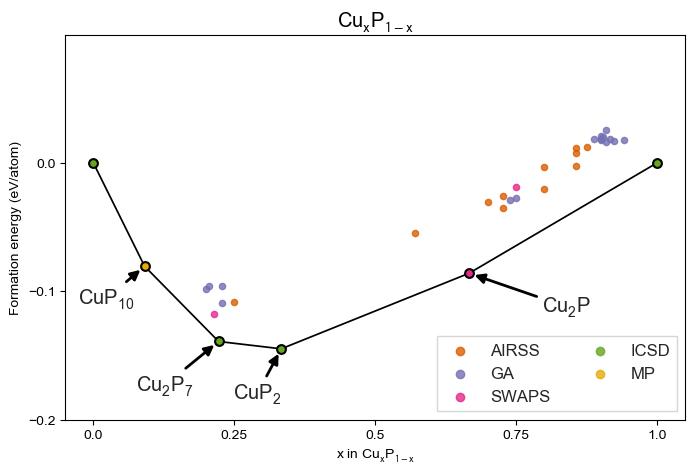

In [7]:
from matador.plotting import plot_2d_hull
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 5))
ax = plot_2d_hull(
    hull,
    ax=ax,
    label_cutoff=8e-3, 
    colour_by_source=True,
    hull_cutoff=0.01,
    plot_hull_points=False,
    show=False,
    alpha=0.8, 
    label_offset=(1.15, 0.02),
    eform_limits=(-0.2, 0.1),
    sources=['ICSD', 'MP', 'SWAPS', 'OQMD', 'GA', 'AIRSS']
)
ax.set_yticks([-0.2, -0.1, 0])
plt.show()
# plt.savefig('CuP-convex-hull.png',bbox_inches='tight',transparent=True)

In [8]:
from matador.utils.cursor_utils import display_results
# Print a table of all the structures with negative formation energy which are also within 50 meV of hull
# currently "summary" means it takes the best structure at each stoich
table_args = {'hull': True, 'summary': True, 'use_source': True}
table_cursor = [doc for doc in hull.cursor if doc['hull_distance'] <= 0.05]
display_results(table_cursor, **table_args)
latex_table = display_results(table_cursor, latex=True, return_str=True, **table_args)
with open('CuP_table.tex', 'w') as f:
    f.write(latex_table)

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  Occurrences 
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493                    0.03       11.3          0.0    Fm-3m          Cu          1      ICSD       1      
  CuP-GA-m0ol1y-7x65                              0.01      193.6         32.9     P-1          Cu16P        1       GA        1      
  CuP-GA-btv80v-5x30                             -0.02      148.3         37.0     P-1          Cu12P        1       GA        1      
  CuP-GA-m0ol1y-2x20                             -0.01      137.2         39.9    C2/m          Cu11P      

### Li-Cu-P ternary

In [ ]:
cursor, failures = res2dict('/u/fs1/afh41/voltage-LiCuP-afh41-LiCuP-noCu2P/*.res', db=True)
cursor = filter_unique_structures(cursor)

if failures:
    print(failures)

Calculating fingerprints...
Running 14 jobs on 16 processes, set by core count.


In [ ]:
# This is the ternary hull used to create the voltage profiles. It has ommitted the disputed Cu-Li
# phases and the high P content Cu-P phases to identify specifically the Cu3P and Cu2P voltage profiles

hull = QueryConvexHull(cursor=cursor,
        #expt='Cu3P-deetrizio-exp.csv',
        #expt='Cu3P-expt-voltage-bichat2004electrochemical.csv',
        expt='/u/fs1/afh41/voltage-LiCuP-afh41-LiCuP-noCu2P/Cu3P-expt-voltage-bichat2004electrochemicalC8.csv',
        expt_label='Cu$_3$P experimental Bichat et al (2004)',
        no_plot=True,
        capmap=True,
        pathways=True,
        subcmd='voltage', 
        elements=['Li', 'Cu', 'P'])

In [ ]:
# remove Cu2P from the plot and calculate the convex hull without Cu2P
noCu2Pcursor = [doc for doc in cursor if doc['stoichiometry'] != [['Cu', 2.0], ['P', 1.0]]]
        
hullnoCu2P = QueryConvexHull(cursor=noCu2Pcursor,
        no_plot=True,
        subcmd='voltage', 
        elements=['Li', 'Cu', 'P'])

In [ ]:
from matador.plotting import plot_voltage_curve
# revert to matador colourscheme
set_settings({'plotting': {'default_style': 'matador'}})

In [ ]:
fig, ax = plt.subplots()
ax = plot_voltage_curve(hull, 
                        ax=ax, curve_label='Cu$_2$P DFT', 
                        line_kwargs={'ls': '-', 'color': 'darkblue'})
ax = plot_voltage_curve(hullnoCu2P, 
                        ax=ax, curve_label='Cu$_3$P DFT', 
                        line_kwargs={'ls': '-', 'color': 'lightblue'})
ax.legend()

In [ ]:
from matador.plotting import plot_spectral
ax = plot_spectral(
    '/u/fs1/afh41/Cu2P-phonon-correct-path/CuP-Ir2P-OQMD_30622-CollCode640898', 
    phonons=True,
    band_colour='purple', 
  #  png=True
)

In [ ]:
# write now displaying as svg is too taxing when there are many thousand points, so switch to png here 
# long-term solution is probably to rewrite pdis plotting to use variable line widths with variable zorder...
set_matplotlib_formats('png')
plot_spectral(
    '/u/fs1/afh41/Cu2P-bands-elec/CuP-Ir2P-OQMD_30622-CollCode640898',
    pdis_interpolation_factor=5,
  #  png=True
)
set_matplotlib_formats('png')

In [ ]:
# this DOS is a bit weird?
plot_spectral(
    '/u/fs1/afh41/P-phonon/P-CollCode150873_prim-out_prim',
    phonons=True,
    band_colour='purple', 
    plot_dos=False,
   # png=True,
)

In [ ]:
from matador.hull.hull_temperature import TemperatureDependentHull 
cursor, failures = castep2dict('/u/fs1/afh41/proj/test-done-from-athena/CuP/*.castep', db=False)
if failures:
    print(failures)
    
temperatures = np.linspace(0, 900, 21)
# me388 todo: add color bar to these plots
hull = TemperatureDependentHull(
    temperatures=temperatures,
    cursor=cursor,
    energy_key='total_energy_per_atom',
    species=['Cu','P']
)
ax = hull.plot_hull(plot_points=True)
lims = ax.get_ylim()
ax.set_ylim(lims[0], 0.02);

In [ ]:
# plot temperature vs. enthalpy for P and P_SCAN
from matador.orm.spectral import VibrationalDOS
P = VibrationalDOS(castep2dict('/u/fs1/afh41/P-phonon/P-CollCode150873_prim-out_prim.castep', db=False)[0])
P_SCAN = VibrationalDOS(castep2dict('/u/fs1/afh41/P-phonon/SCAN/P-CollCode150873_prim-out_prim.castep', db=False)[0])

In [ ]:
import numpy as np
temperatures = np.linspace(0, 450, 21)
fig, ax = plt.subplots()
ax.set_title('Vibrational free energy of black phosphorus with PBE vs rSCAN')
P.plot_free_energy(temperatures=temperatures, ax=ax, line_kwargs={'label': f'PBE $\\Delta={P.zpe:.4f}$ eV/atom'})
P_SCAN.plot_free_energy(temperatures=temperatures, ax=ax, line_kwargs={'label': f'rSCAN $\\Delta={P_SCAN.zpe:.4f}$ eV/atom'})
ax.legend()

In [ ]:
import numpy as np
from scipy.constants import physical_constants
cursor, failures = castep2dict('/u/fs1/afh41/proj/test-done-from-athena/CuP/*.castep', db=False)

k = physical_constants['Boltzmann constant in eV/K'][0]
S = k * np.log(3) # Configurational Entropy S = kln(w)
T = 300 

for ind, doc in enumerate(cursor):
    dos = VibrationalDOS(doc)
    
    if doc['stoichiometry'] == [['Cu', 8.0], ['P', 3.0]]:
        entropy_contrib = S*T
    else:
        entropy_contrib = 0
    doc['300_free_energy'] = doc['smeared_free_energy'] + dos.vibrational_free_energy(T) - entropy_contrib
    doc['300_free_energy_per_atom'] = doc['300_free_energy'] / doc['num_atoms']
    
hull = QueryConvexHull(
    cursor=cursor,
    energy_key='300_free_energy',
    species=['Cu','P']
)